# Importowanie

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
import seaborn as sns

# Wczytywanie danych

Na początek wczytajmy nasz zbiór `titanic.csv`:

In [ ]:
df = pd.read_csv('titanic.csv')

In [ ]:
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


# Analiza danych / preprocessing

## Informacje ogólne

Przjrzyjmy się teraz nieco dokładniej poszczególnym kolumnom

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home_dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


Już tutaj widzimy, że są kolumny, które mają w sobie bardzo mało wartości innych niż `NaN`, pochylimy się nad tym za chwilę, teraz trochę o kolumnach typu `object`...:

In [ ]:
df.describe(include='O')

,name,sex,ticket,cabin,embarked,boat,home_dest
count,1309,1309,1309,295,1307,486,745
unique,1307,2,929,186,3,27,369
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S,13,"New York, NY"
freq,2,843,11,6,914,39,64


... oraz o kolumnach typu numerycznego:

In [ ]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


## Usuwanie zbędnych kolumn

Widzimy wyżej, że nasz zbiór zawiera 13 kolumn po 1309 wartości każda. Warto jednak nadmienić, że niektóre z nich nie będą nam potrzebne:
- `boat`: wskazuje na numer łodzi ratunkowej, którą dana osoba uciekła.
- `body`: wskazuje na numer identyfikacyjny zwłok. Ta i poprzednia wartość daje jednoznaczną informację o przeżyciu danej osoby, co w oczywisty sposób powoduje wyciek danych.
- `home_dest`: wskazuje na miasto, do którego udała się dana osoba, nie ma to żadnego wpływu na przeżycie danej osoby.
- `ticket`: numer biletu, nie ma to wpływu na przeżycie danej osoby.
- `embarked`: miejsce wejścia na pokład, tak jak wyżej.

Oprócz tego, z racji że kolumna `survived` jest już zapisana binarnie, odetniemy ją z naszego `df` do zmiennej `y`, a całą resztę (nie licząc niepotrzebnych kolumn, które usuniemy) umiejscowimy w zmiennej `X`:

In [ ]:
y = df['survived']
X = df.drop(columns=["survived","ticket","boat","body","home_dest", 'embarked'])
X

,pclass,name,sex,age,sibsp,parch,fare,cabin
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,211.3375,B5
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,151.5500,C22 C26
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,151.5500,C22 C26
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,151.5500,C22 C26
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,151.5500,C22 C26
...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.5000,1,0,14.4542,NaN
1305,3,"Zabour, Miss. Thamine",female,NaN,1,0,14.4542,NaN
1306,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,7.2250,NaN
1307,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,7.2250,NaN


Oprócz tego, jeżeli jeszcze raz przyjrzymy się ilości `NaN` w poszczególnych kolumnach:

In [ ]:
X.isna().sum()

pclass       0
name         0
sex          0
age        263
sibsp        0
parch        0
fare         1
cabin     1014
dtype: int64

Łatwo zauważyć, że kolumna `cabin` zawiera ich bardzo dużo. Zobaczmy jak to wygląda w procentach:

In [ ]:
na = X.isna().sum() / len(X) * 100
na

pclass     0.000000
name       0.000000
sex        0.000000
age       20.091673
sibsp      0.000000
parch      0.000000
fare       0.076394
cabin     77.463713
dtype: float64

Prawie 80% wartości `NaN`. Ta kolumna raczej będzie dla nas nieużyteczna, dlatego też pozbędziemy się jej z naszego zbioru:

In [ ]:
X = X.drop(columns=['cabin'])
X

,pclass,name,sex,age,sibsp,parch,fare
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,211.3375
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,151.5500
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,151.5500
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,151.5500
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,151.5500
...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.5000,1,0,14.4542
1305,3,"Zabour, Miss. Thamine",female,NaN,1,0,14.4542
1306,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,7.2250
1307,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,7.2250


Z resztą brakujących wartości tj. w kolumnach `age` oraz `fare` poradzimy sobie w krótce.

## Sprawdzenie korelacji zmiennych

Zanim przejdziemy do wizualizacji, zajmijmy się jeszcze korelacją danych, gdyż być może są jeszcze jakieś kolumny, które nie są nam potrzebne:

<ipython-input-951-91d5c796b607>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X.corr()


<Axes: >

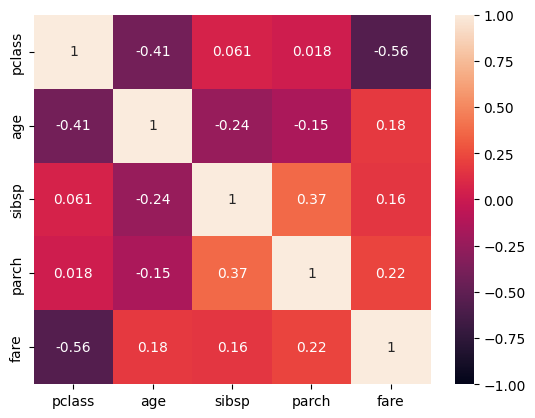

In [ ]:
correlation = X.corr()
sns.heatmap(correlation, vmin=-1,vmax=1,annot=True)

Jak widać, najwyższa korelacja występuje pomiędzy `fare` a `pclass`. Jest to jasne ze względu na powiązanie ceny biletu oraz klasy na titanic'u, jednak nie jest to aż tak duża korelacja, aby podjąć decyzję o rezygnacji z jednej z kolumn.

## Wizualizacja danych

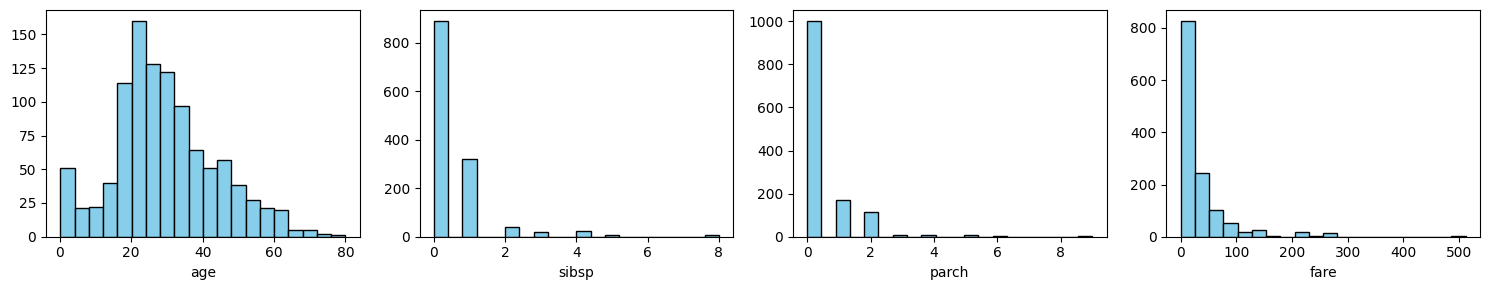

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))

axes = axes.flatten()
columns = ['age', 'sibsp', 'parch', 'fare']
for i,column in enumerate(columns):
  ax = axes[i]
  ax.hist(X[column], bins=20, color='skyblue', edgecolor='black')
  ax.set_xlabel(column)

plt.tight_layout()



plt.show()

Znakomita większość pasażerów:
- nie miała na statku rodzeństwa, dzieci ani rodziców (którzy z nimi by płynęli).
- zapłaciło niedużo za bilet.
- była w przedziale wiekowym 16-32.

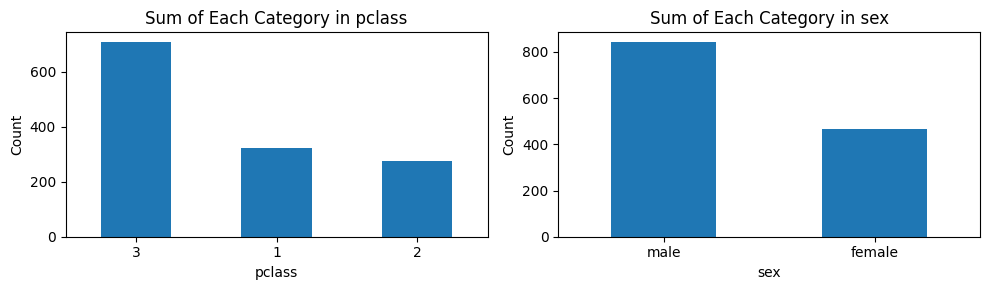

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

axes = axes.flatten()
columns = ['pclass','sex']
for i,column in enumerate(columns):
  ax = axes[i]
  category_counts = X[column].value_counts()
  category_counts.plot(kind='bar', ax=ax,rot=0)
  ax.set_title(f'Sum of Each Category in {column}')
  ax.set_xlabel(column)
  ax.set_ylabel('Count')


plt.tight_layout()

plt.show()

Idąc dalej w rozważaniach:
- przewaga klasy 3 (znowu widać korelację z ceną za bilet).
- przewaga mężczyzn nad kobietami.

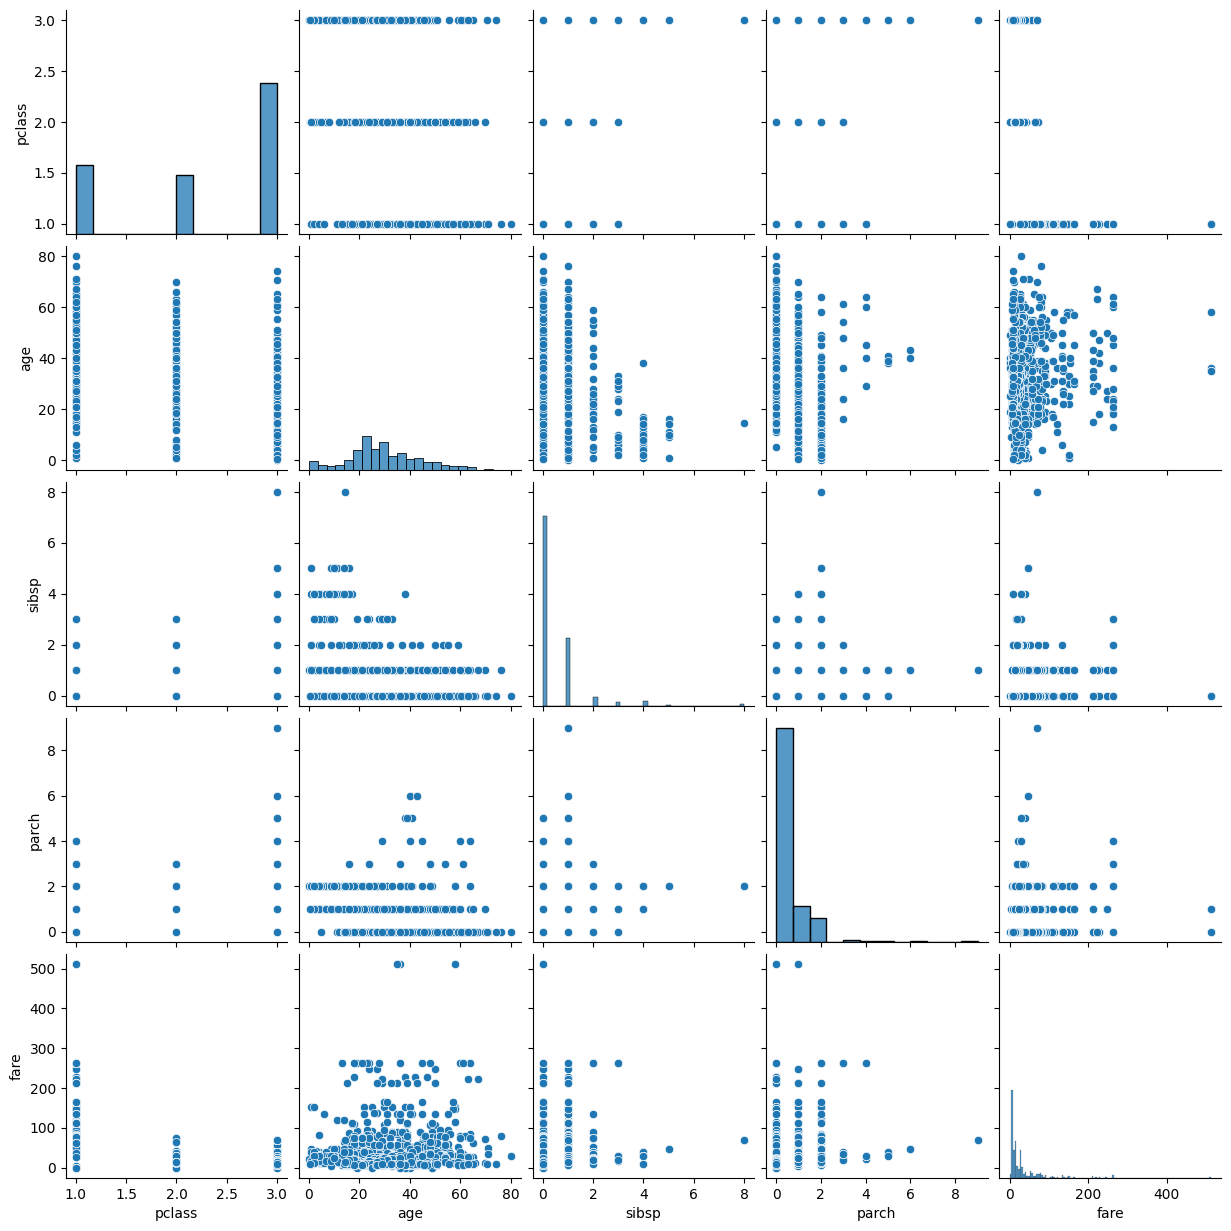

In [ ]:
sns.pairplot(X)

## Feature enginering

Zajmiemy się  teraz tworzeniem dodatkowych kolumn, które pomogą nam w późniejszym procesie uczenia, jednak zanim to, musimy uzupełnić wartości w kolumnie `age`:

### Uzupełnienie wartości age ze względu na posiadany tytuł.

Stwórzmy najpierw kolumnę, która zawierać będzie tytuły poszczególnych osób:

In [ ]:
X['title'] = X['name'].str.extract(' ([A-Za-z]+)\.')
X

,pclass,name,sex,age,sibsp,parch,fare,title
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,211.3375,Miss
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,151.5500,Master
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,151.5500,Miss
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,151.5500,Mr
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,151.5500,Mrs
...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.5000,1,0,14.4542,Miss
1305,3,"Zabour, Miss. Thamine",female,NaN,1,0,14.4542,Miss
1306,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,7.2250,Mr
1307,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,7.2250,Mr


Teraz, wystarczy tylko policzyć średnie dla każdej grupy, zaaplikować je tam gdzie mamy wartości `NaN`, a na koniec usunąć kolumnę `title`:

In [ ]:
title_means = X.groupby('title')['age'].mean()

X['age'] = X.apply(lambda row: title_means[row['title']] if pd.isna(row['age']) else row['age'], axis=1)

X = X.drop(columns=['title'])
X

,pclass,name,sex,age,sibsp,parch,fare
0,1,"Allen, Miss. Elisabeth Walton",female,29.000000,0,0,211.3375
1,1,"Allison, Master. Hudson Trevor",male,0.916700,1,2,151.5500
2,1,"Allison, Miss. Helen Loraine",female,2.000000,1,2,151.5500
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,1,2,151.5500
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,1,2,151.5500
...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.500000,1,0,14.4542
1305,3,"Zabour, Miss. Thamine",female,21.774207,1,0,14.4542
1306,3,"Zakarian, Mr. Mapriededer",male,26.500000,0,0,7.2250
1307,3,"Zakarian, Mr. Ortin",male,27.000000,0,0,7.2250


In [ ]:
X.isnull().sum()

pclass    0
name      0
sex       0
age       0
sibsp     0
parch     0
fare      1
dtype: int64

Do uzupełnienia zostały nam teraz jedynie `fare` oraz `embarked`, ale to później.

### Tworzenie dodatkowych kolumn

Najpierw stworzymy kolumnę, która będzie zawierać przedział wiekowy danej osoby:

In [ ]:
def age_range(age):
  if age < 6:
    return 'newborn'
  if age >= 6 and age < 12:
    return 'child'
  if age >= 12 and age < 18:
    return 'teen'
  if age >= 18:
    return 'adult'

X['age_range'] = X['age'].apply(age_range)
X

,pclass,name,sex,age,sibsp,parch,fare,age_range
0,1,"Allen, Miss. Elisabeth Walton",female,29.000000,0,0,211.3375,adult
1,1,"Allison, Master. Hudson Trevor",male,0.916700,1,2,151.5500,newborn
2,1,"Allison, Miss. Helen Loraine",female,2.000000,1,2,151.5500,newborn
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,1,2,151.5500,adult
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,1,2,151.5500,adult
...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.500000,1,0,14.4542,teen
1305,3,"Zabour, Miss. Thamine",female,21.774207,1,0,14.4542,adult
1306,3,"Zakarian, Mr. Mapriededer",male,26.500000,0,0,7.2250,adult
1307,3,"Zakarian, Mr. Ortin",male,27.000000,0,0,7.2250,adult


Następnie dodajmy taką, która zawierać będzie wielkość rodziny na statku (włącznie z tą osobą):

In [ ]:
X['family_size'] = X['parch'] + X['sibsp'] + 1
X

,pclass,name,sex,age,sibsp,parch,fare,age_range,family_size
0,1,"Allen, Miss. Elisabeth Walton",female,29.000000,0,0,211.3375,adult,1
1,1,"Allison, Master. Hudson Trevor",male,0.916700,1,2,151.5500,newborn,4
2,1,"Allison, Miss. Helen Loraine",female,2.000000,1,2,151.5500,newborn,4
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,1,2,151.5500,adult,4
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,1,2,151.5500,adult,4
...,...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.500000,1,0,14.4542,teen,2
1305,3,"Zabour, Miss. Thamine",female,21.774207,1,0,14.4542,adult,2
1306,3,"Zakarian, Mr. Mapriededer",male,26.500000,0,0,7.2250,adult,1
1307,3,"Zakarian, Mr. Ortin",male,27.000000,0,0,7.2250,adult,1


Na koniec jeszcze taka, która przechowywać będzie priorytet na przeżycie dla danej osoby (im niższa wartość tym wyższy priorytet):

In [ ]:
X['mpc'] = X['age']*X['pclass']
X

,pclass,name,sex,age,sibsp,parch,fare,age_range,family_size,mpc
0,1,"Allen, Miss. Elisabeth Walton",female,29.000000,0,0,211.3375,adult,1,29.00000
1,1,"Allison, Master. Hudson Trevor",male,0.916700,1,2,151.5500,newborn,4,0.91670
2,1,"Allison, Miss. Helen Loraine",female,2.000000,1,2,151.5500,newborn,4,2.00000
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,1,2,151.5500,adult,4,30.00000
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,1,2,151.5500,adult,4,25.00000
...,...,...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.500000,1,0,14.4542,teen,2,43.50000
1305,3,"Zabour, Miss. Thamine",female,21.774207,1,0,14.4542,adult,2,65.32262
1306,3,"Zakarian, Mr. Mapriededer",male,26.500000,0,0,7.2250,adult,1,79.50000
1307,3,"Zakarian, Mr. Ortin",male,27.000000,0,0,7.2250,adult,1,81.00000


Sprawdźmy teraz macierz korelacji, uwzględniając nowo utworzone zmienne:

<ipython-input-963-91d5c796b607>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = X.corr()


<Axes: >

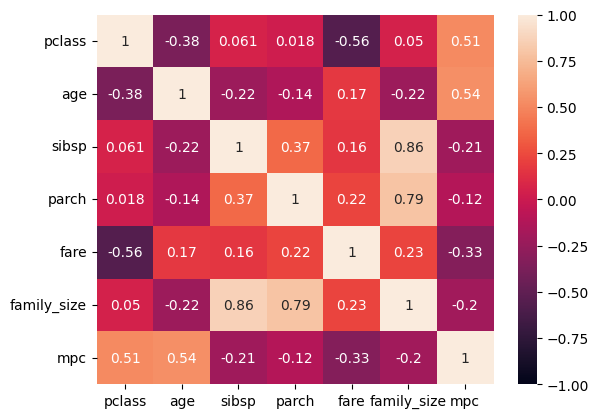

In [ ]:
correlation = X.corr()
sns.heatmap(correlation, vmin=-1,vmax=1,annot=True)

Widzimy bardzo dużą zależność `family_size` oraz kolumn `sibsp`, `parch`. Usuńmy te dwie na rzecz nowo stworzonej

In [ ]:
X = X.drop(columns=['sibsp','parch'])
X

,pclass,name,sex,age,fare,age_range,family_size,mpc
0,1,"Allen, Miss. Elisabeth Walton",female,29.000000,211.3375,adult,1,29.00000
1,1,"Allison, Master. Hudson Trevor",male,0.916700,151.5500,newborn,4,0.91670
2,1,"Allison, Miss. Helen Loraine",female,2.000000,151.5500,newborn,4,2.00000
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,151.5500,adult,4,30.00000
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,151.5500,adult,4,25.00000
...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.500000,14.4542,teen,2,43.50000
1305,3,"Zabour, Miss. Thamine",female,21.774207,14.4542,adult,2,65.32262
1306,3,"Zakarian, Mr. Mapriededer",male,26.500000,7.2250,adult,1,79.50000
1307,3,"Zakarian, Mr. Ortin",male,27.000000,7.2250,adult,1,81.00000


Na koniec możemy odrzucić z naszego zbioru kolumnę `name`, gdyż nie będzie nam ona już potrzebna:

In [ ]:
X = X.drop(columns=['name'])
X

,pclass,sex,age,fare,age_range,family_size,mpc
0,1,female,29.000000,211.3375,adult,1,29.00000
1,1,male,0.916700,151.5500,newborn,4,0.91670
2,1,female,2.000000,151.5500,newborn,4,2.00000
3,1,male,30.000000,151.5500,adult,4,30.00000
4,1,female,25.000000,151.5500,adult,4,25.00000
...,...,...,...,...,...,...,...
1304,3,female,14.500000,14.4542,teen,2,43.50000
1305,3,female,21.774207,14.4542,adult,2,65.32262
1306,3,male,26.500000,7.2250,adult,1,79.50000
1307,3,male,27.000000,7.2250,adult,1,81.00000


## Wypełnianie wartości NaN

Dobrze, teraz czas na uzupełnienie pozostałych wartości `NaN` w naszym zbiorze:

In [ ]:
percent_missing = X.isna().sum()
percent_missing

pclass         0
sex            0
age            0
fare           1
age_range      0
family_size    0
mpc            0
dtype: int64

Tu warto zaznaczyć, że wartości pustych jest w naszym przypadku tak mało, iż nie ma zbyt dużego sensu sięgać aż po imputery (można by było uzupełnić je ręcznie), jednak zobaczmy ich działanie, chociażby w celach dydaktycznych:

In [ ]:
impute_num = IterativeImputer(missing_values=np.nan, initial_strategy='mean')
column_t = ColumnTransformer([('pass', 'passthrough', slice(0,3)),
                              ('impute_fare', impute_num, [3]),
                              ('pass2', 'passthrough', slice(4,7)),],
                             verbose_feature_names_out=False)

column_t.set_output(transform='pandas')
X = pd.DataFrame(column_t.fit_transform(X),columns=column_t.get_feature_names_out())
X

,pclass,sex,age,fare,age_range,family_size,mpc
0,1,female,29.000000,211.3375,adult,1,29.00000
1,1,male,0.916700,151.5500,newborn,4,0.91670
2,1,female,2.000000,151.5500,newborn,4,2.00000
3,1,male,30.000000,151.5500,adult,4,30.00000
4,1,female,25.000000,151.5500,adult,4,25.00000
...,...,...,...,...,...,...,...
1304,3,female,14.500000,14.4542,teen,2,43.50000
1305,3,female,21.774207,14.4542,adult,2,65.32262
1306,3,male,26.500000,7.2250,adult,1,79.50000
1307,3,male,27.000000,7.2250,adult,1,81.00000


In [ ]:
X.isna().sum()

pclass         0
sex            0
age            0
fare           0
age_range      0
family_size    0
mpc            0
dtype: int64

Jak widzimy wszystkie wartości są już uzupełnione.

## Usunięcie wartości odstających


Teraz czas na zajęcie się wartościami odstającymi, zobaczmy gdzie się one znajdują:

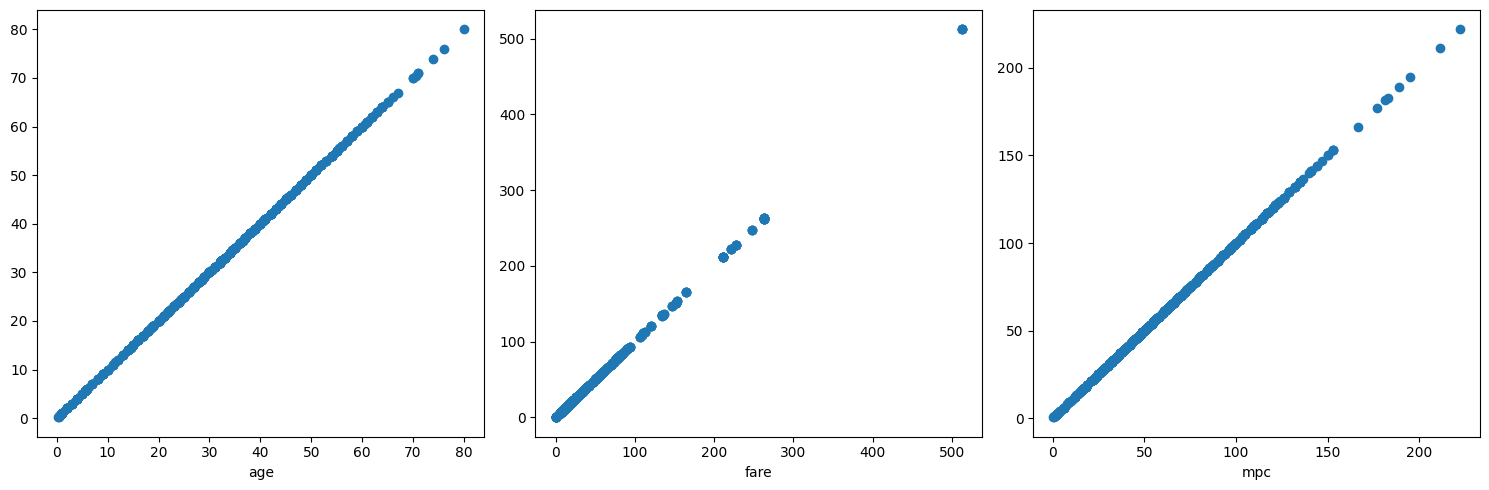

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

axes = axes.flatten()
columns = ['age', 'fare','mpc']
for i,column in enumerate(columns):
  ax = axes[i]
  ax.scatter(X[column],X[column])
  ax.set_xlabel(column)

plt.tight_layout()

plt.show()

In [ ]:
X['pclass'] = X['pclass'].astype(object)
X1 = X.drop(columns=['family_size'])
for column in X1.select_dtypes(include='number').columns:
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1

    X[column] = X[column].where((X[column] >= Q1 - 1.5 * IQR) & (X[column] <= Q3 + 1.5 * IQR), X[column].mean())

column_t.set_output(transform='pandas')
X = pd.DataFrame(column_t.fit_transform(X),columns=column_t.get_feature_names_out())
X

,pclass,sex,age,fare,age_range,family_size,mpc
0,1,female,29.000000,33.295479,adult,1,29.00000
1,1,male,0.916700,33.295479,newborn,4,0.91670
2,1,female,2.000000,33.295479,newborn,4,2.00000
3,1,male,30.000000,33.295479,adult,4,30.00000
4,1,female,25.000000,33.295479,adult,4,25.00000
...,...,...,...,...,...,...,...
1304,3,female,14.500000,14.454200,teen,2,43.50000
1305,3,female,21.774207,14.454200,adult,2,65.32262
1306,3,male,26.500000,7.225000,adult,1,79.50000
1307,3,male,27.000000,7.225000,adult,1,81.00000


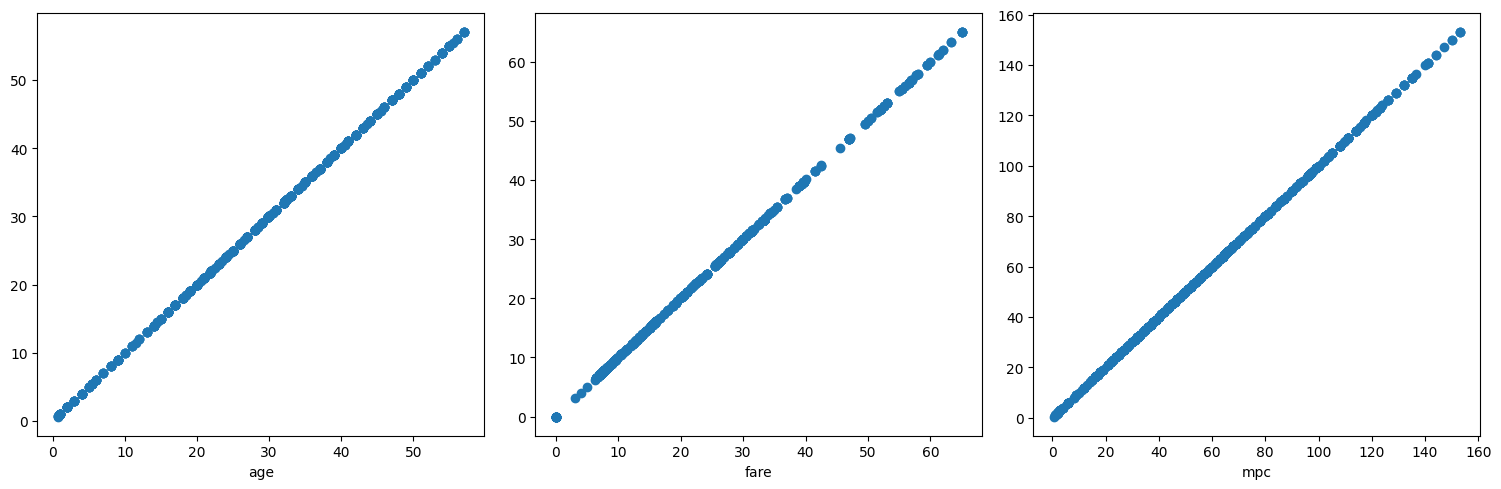

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes = axes.flatten()
columns = ['age', 'fare', 'mpc']
for i,column in enumerate(columns):
  ax = axes[i]
  ax.scatter(X[column],X[column])
  ax.set_xlabel(column)

plt.tight_layout()

plt.show()

Jak widzimy, teraz nasze zmienne nie mają tak odległych od siebie wartości.

## Normalizacja

Aby nasz model mógł dobrze dobrać wpływ danych zmiennych na przeżycie osoby, konieczna jest normalizacja kolumn numerycznych, użyjmy do tego `MinMaxScaler`:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

to_normalize = X.select_dtypes(np.number)
X[to_normalize.columns] = MinMaxScaler().fit_transform(to_normalize)
X

,pclass,sex,age,fare,age_range,family_size,mpc
0,1,female,0.502958,0.512238,adult,0.0,0.186885
1,1,male,0.004438,0.512238,newborn,0.3,0.002732
2,1,female,0.023668,0.512238,newborn,0.3,0.009835
3,1,male,0.520710,0.512238,adult,0.3,0.193442
4,1,female,0.431952,0.512238,adult,0.3,0.160655
...,...,...,...,...,...,...,...
1304,3,female,0.245562,0.222372,teen,0.1,0.281967
1305,3,female,0.374690,0.222372,adult,0.1,0.425066
1306,3,male,0.458580,0.111154,adult,0.0,0.518032
1307,3,male,0.467455,0.111154,adult,0.0,0.527869


## Kodowanie zmiennych kategorycznych

Z racji na to, że będziemy używać dwóch różnych zbiorów treningowych (jeden z mniejszą ilością zmiennych), stworzymy nowy zbiór `X_less`:

In [ ]:
X_less = X.drop(columns=['family_size','mpc'])
X_less = pd.get_dummies(X_less, columns=['pclass','sex','age_range'])
X_less

<ipython-input-973-cb651686de14>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X_less = pd.get_dummies(X_less, columns=['pclass','sex','age_range'])


,age,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,age_range_adult,age_range_child,age_range_newborn,age_range_teen
0,0.502958,0.512238,1,0,0,1,0,1,0,0,0
1,0.004438,0.512238,1,0,0,0,1,0,0,1,0
2,0.023668,0.512238,1,0,0,1,0,0,0,1,0
3,0.520710,0.512238,1,0,0,0,1,1,0,0,0
4,0.431952,0.512238,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1304,0.245562,0.222372,0,0,1,1,0,0,0,0,1
1305,0.374690,0.222372,0,0,1,1,0,1,0,0,0
1306,0.458580,0.111154,0,0,1,0,1,1,0,0,0
1307,0.467455,0.111154,0,0,1,0,1,1,0,0,0


Teraz to samo dla naszego podstawowego zbioru:

In [ ]:
X = pd.get_dummies(X, columns=['pclass','sex','age_range'])
X

<ipython-input-974-a04b9df4c68f>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X = pd.get_dummies(X, columns=['pclass','sex','age_range'])


,age,fare,family_size,mpc,pclass_1,pclass_2,pclass_3,sex_female,sex_male,age_range_adult,age_range_child,age_range_newborn,age_range_teen
0,0.502958,0.512238,0.0,0.186885,1,0,0,1,0,1,0,0,0
1,0.004438,0.512238,0.3,0.002732,1,0,0,0,1,0,0,1,0
2,0.023668,0.512238,0.3,0.009835,1,0,0,1,0,0,0,1,0
3,0.520710,0.512238,0.3,0.193442,1,0,0,0,1,1,0,0,0
4,0.431952,0.512238,0.3,0.160655,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0.245562,0.222372,0.1,0.281967,0,0,1,1,0,0,0,0,1
1305,0.374690,0.222372,0.1,0.425066,0,0,1,1,0,1,0,0,0
1306,0.458580,0.111154,0.0,0.518032,0,0,1,0,1,1,0,0,0
1307,0.467455,0.111154,0.0,0.527869,0,0,1,0,1,1,0,0,0


In [ ]:
y

0       1
1       1
2       0
3       0
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    0
Name: survived, Length: 1309, dtype: int64

## Przygotowanie zestawów danych treningowych i testowych

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_less, y, test_size=0.2, random_state=1, stratify=y)

# Klasyfikacja

Dla każdego modelu, sprawdzać będziemy takie metryki jak dokładność, precyzja, wynik-F1 itp. Posłuży nam do tego bardzo przydatna funkcja `classification_report`, która daje nam te informacje w czytelnym formacie.

Oprócz tego sporządzimy odpowiednie macierze pomyłek dla zbioru treningowego oraz testowego, a poza tym wykresy ROC.

In [ ]:
metrics = {"accuracy":[], "precision":[], "recall":[], "f1-score":[]}

## Perceptron

Na początek zaczniemy od zwykłego perceptrona

In [ ]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train, y_train)

Perceptron(eta0=0.1, random_state=1)

In [ ]:
y_pred_train = ppn.predict(X_train)
y_pred_test = ppn.predict(X_test)

In [ ]:
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test))
metrics["precision"].append(precision_score(y_test, y_pred_test))
metrics["recall"].append(recall_score(y_test, y_pred_test))
metrics["f1-score"].append(f1_score(y_test, y_pred_test))

In [ ]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       162
           1       0.67      0.78      0.72       100

    accuracy                           0.77       262
   macro avg       0.76      0.77      0.76       262
weighted avg       0.78      0.77      0.77       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train, cm_test

(array([[445, 202],
        [ 78, 322]]),
 array([[123,  39],
        [ 22,  78]]))

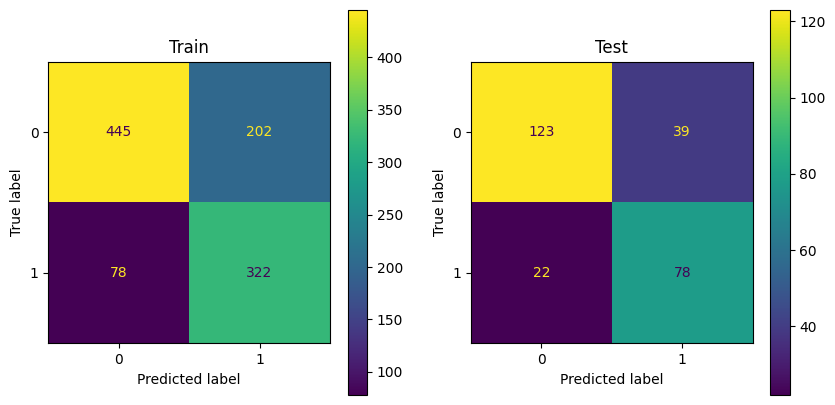

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

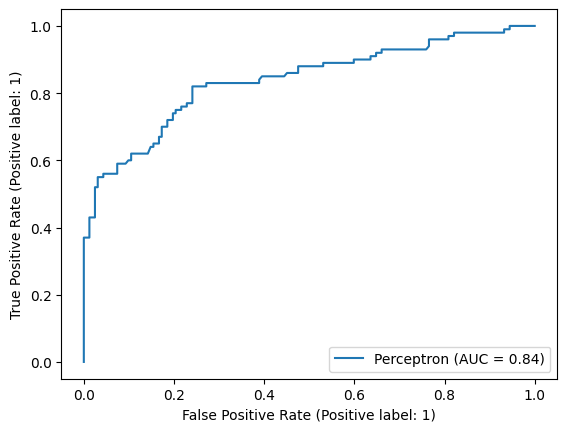

In [ ]:
RocCurveDisplay.from_estimator(ppn,X_test,y_test)

## SGDClassifier


In [ ]:
sgd = SGDClassifier(loss="log_loss").fit(X_train,y_train)

In [ ]:
y_pred_train_sgd = sgd.predict(X_train)
y_pred_train_sgd

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
y_pred_test_sgd = sgd.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_sgd))
metrics["precision"].append(precision_score(y_test, y_pred_test_sgd))
metrics["recall"].append(recall_score(y_test, y_pred_test_sgd))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_sgd))

In [ ]:
print(classification_report(y_test,y_pred_test_sgd))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       162
           1       0.93      0.54      0.68       100

    accuracy                           0.81       262
   macro avg       0.85      0.76      0.77       262
weighted avg       0.83      0.81      0.79       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_sgd)
cm_test = confusion_matrix(y_test, y_pred_test_sgd)
cm_train, cm_test

(array([[628,  19],
        [208, 192]]),
 array([[158,   4],
        [ 46,  54]]))

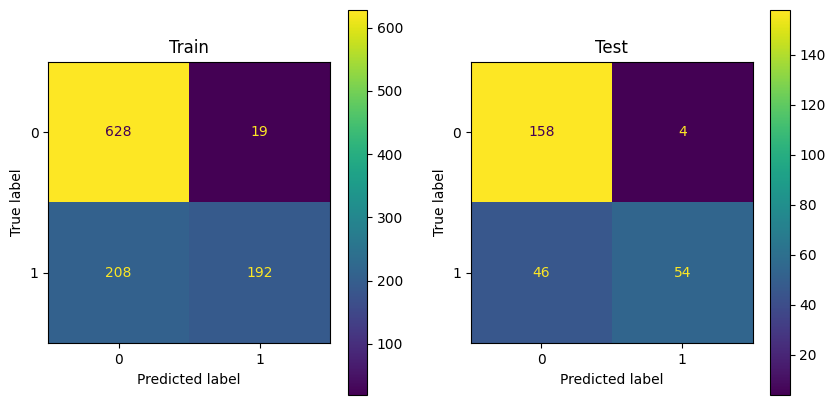

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

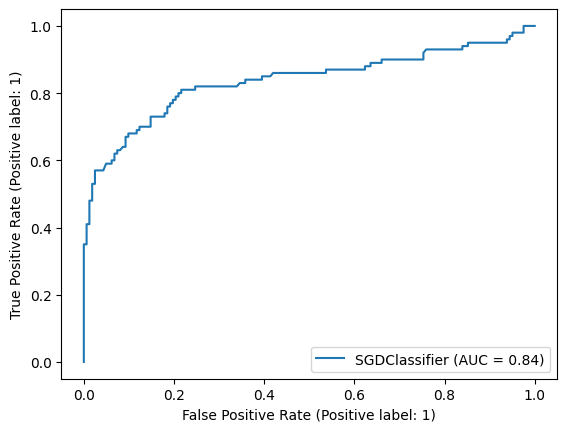

In [ ]:
RocCurveDisplay.from_estimator(sgd,X_test,y_test)

## DecisionTreeClassifier


[Text(0.4583333333333333, 0.9, 'x[6] <= 0.5\ngini = 0.472\nsamples = 1047\nvalue = [647, 400]'),
 Text(0.22916666666666666, 0.7, 'x[4] <= 0.5\ngini = 0.405\nsamples = 373\nvalue = [105, 268]'),
 Text(0.125, 0.5, 'x[0] <= 0.982\ngini = 0.133\nsamples = 196\nvalue = [14, 182]'),
 Text(0.08333333333333333, 0.3, 'x[1] <= 0.487\ngini = 0.124\nsamples = 195\nvalue = [13, 182]'),
 Text(0.041666666666666664, 0.1, 'gini = 0.21\nsamples = 84\nvalue = [10, 74]'),
 Text(0.125, 0.1, 'gini = 0.053\nsamples = 111\nvalue = [3, 108]'),
 Text(0.16666666666666666, 0.3, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.3333333333333333, 0.5, 'x[1] <= 0.359\ngini = 0.5\nsamples = 177\nvalue = [91, 86]'),
 Text(0.25, 0.3, 'x[0] <= 0.459\ngini = 0.492\nsamples = 147\nvalue = [64, 83]'),
 Text(0.20833333333333334, 0.1, 'gini = 0.465\nsamples = 98\nvalue = [36, 62]'),
 Text(0.2916666666666667, 0.1, 'gini = 0.49\nsamples = 49\nvalue = [28, 21]'),
 Text(0.4166666666666667, 0.3, 'x[1] <= 0.498\ngini = 0.18\nsam

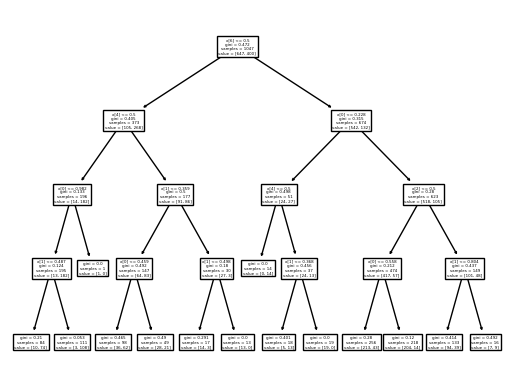

In [ ]:
DTC = DecisionTreeClassifier(max_depth=4).fit(X_train,y_train)
plot_tree(DTC)

In [ ]:
y_pred_train_DTC = DTC.predict(X_train)
y_pred_train_DTC

array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
y_pred_test_DTC = DTC.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_DTC))
metrics["precision"].append(precision_score(y_test, y_pred_test_DTC))
metrics["recall"].append(recall_score(y_test, y_pred_test_DTC))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_DTC))

In [ ]:
print(classification_report(y_test,y_pred_test_DTC))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       162
           1       0.77      0.69      0.73       100

    accuracy                           0.80       262
   macro avg       0.79      0.78      0.79       262
weighted avg       0.80      0.80      0.80       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_DTC)
cm_test = confusion_matrix(y_test, y_pred_test_DTC)
cm_train, cm_test

(array([[586,  61],
        [120, 280]]),
 array([[141,  21],
        [ 31,  69]]))

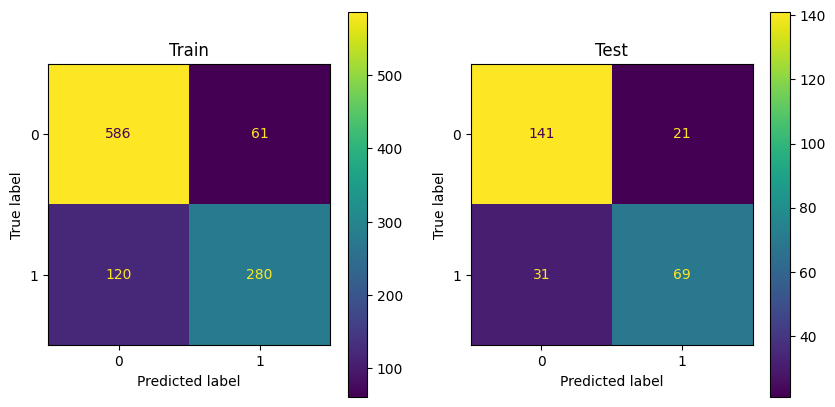

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

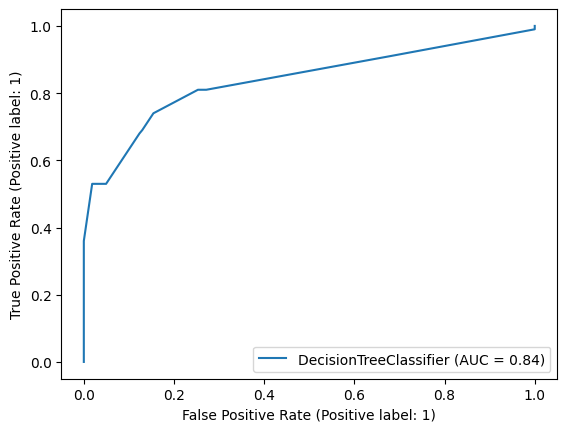

In [ ]:
RocCurveDisplay.from_estimator(DTC,X_test,y_test)

## LogisticRegresion

In [ ]:
lr = LogisticRegression().fit(X_train,y_train)

In [ ]:
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_lr))
metrics["precision"].append(precision_score(y_test, y_pred_test_lr))
metrics["recall"].append(recall_score(y_test, y_pred_test_lr))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_lr))

In [ ]:
print(classification_report(y_test,y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       162
           1       0.79      0.70      0.74       100

    accuracy                           0.81       262
   macro avg       0.81      0.79      0.80       262
weighted avg       0.81      0.81      0.81       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_lr)
cm_test = confusion_matrix(y_test, y_pred_test_lr)
cm_train, cm_test

(array([[558,  89],
        [129, 271]]),
 array([[143,  19],
        [ 30,  70]]))

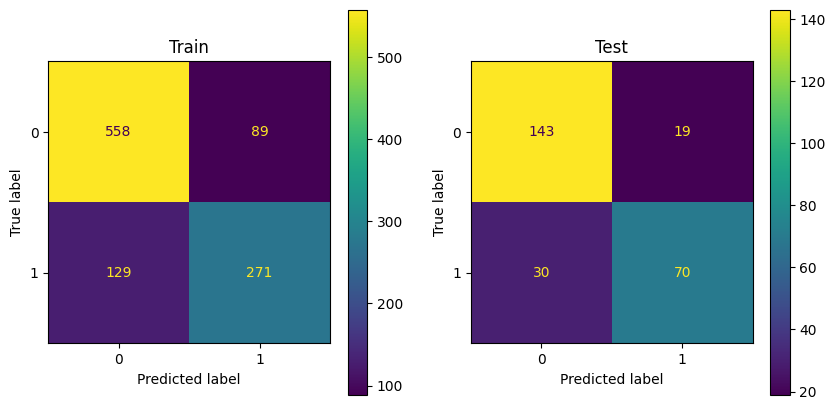

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

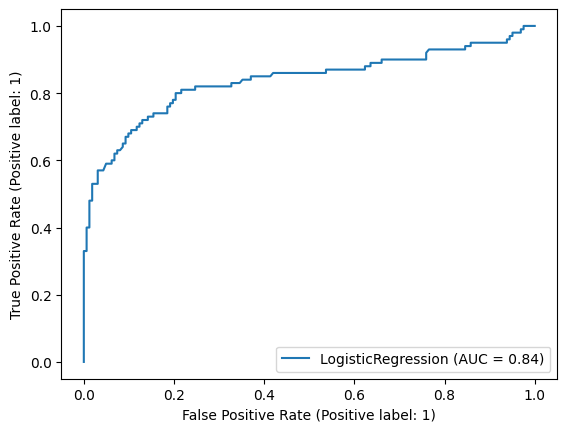

In [ ]:
RocCurveDisplay.from_estimator(lr,X_test,y_test)

## KNeighborsClassifier

In [ ]:
kn = KNeighborsClassifier().fit(X_train,y_train)

In [ ]:
y_pred_train_kn = kn.predict(X_train)
y_pred_test_kn = kn.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_kn))
metrics["precision"].append(precision_score(y_test, y_pred_test_kn))
metrics["recall"].append(recall_score(y_test, y_pred_test_kn))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_kn))

In [ ]:
print(classification_report(y_test,y_pred_test_kn))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       162
           1       0.76      0.70      0.73       100

    accuracy                           0.80       262
   macro avg       0.79      0.78      0.79       262
weighted avg       0.80      0.80      0.80       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_kn)
cm_test = confusion_matrix(y_test, y_pred_test_kn)
cm_train, cm_test

(array([[591,  56],
        [104, 296]]),
 array([[140,  22],
        [ 30,  70]]))

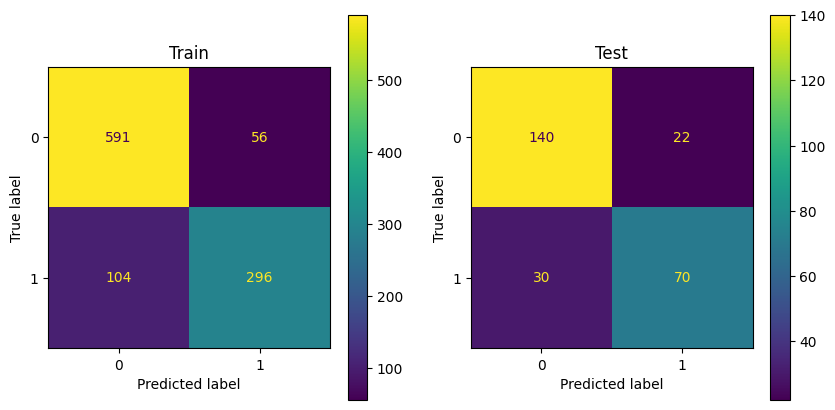

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

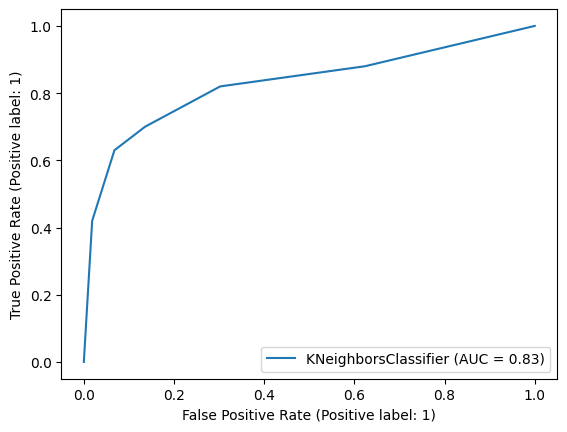

In [ ]:
RocCurveDisplay.from_estimator(kn,X_test,y_test)

## RandomForestClassifier


In [ ]:
rfc = RandomForestClassifier().fit(X_train,y_train)

In [ ]:
y_pred_train_rfc = rfc.predict(X_train)
y_pred_test_rfc = rfc.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_rfc))
metrics["precision"].append(precision_score(y_test, y_pred_test_rfc))
metrics["recall"].append(recall_score(y_test, y_pred_test_rfc))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_rfc))

In [ ]:
print(classification_report(y_test,y_pred_test_rfc))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       162
           1       0.74      0.74      0.74       100

    accuracy                           0.80       262
   macro avg       0.79      0.79      0.79       262
weighted avg       0.80      0.80      0.80       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_rfc)
cm_test = confusion_matrix(y_test, y_pred_test_rfc)
cm_train, cm_test

(array([[629,  18],
        [ 19, 381]]),
 array([[136,  26],
        [ 26,  74]]))

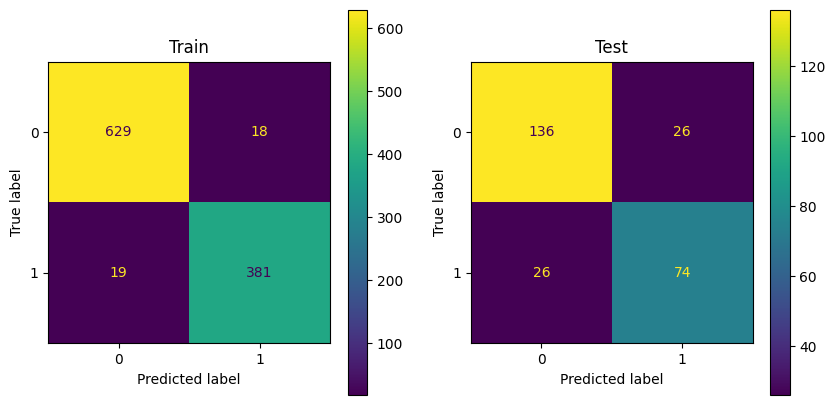

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

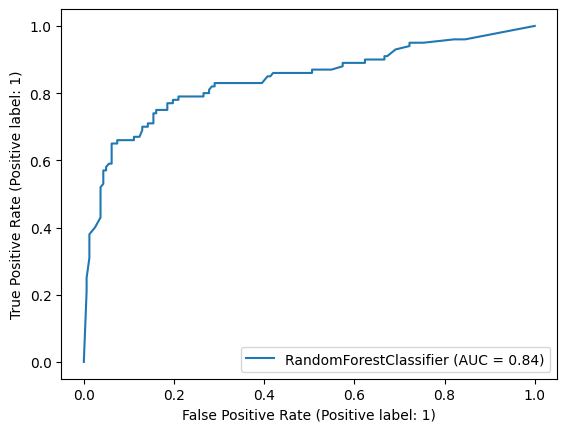

In [ ]:
RocCurveDisplay.from_estimator(rfc,X_test,y_test)

## SVC

In [ ]:
svc = SVC().fit(X_train,y_train)

In [ ]:
y_pred_train_svc = svc.predict(X_train)
y_pred_test_svc = svc.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_svc))
metrics["precision"].append(precision_score(y_test, y_pred_test_svc))
metrics["recall"].append(recall_score(y_test, y_pred_test_svc))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_svc))

In [ ]:
print(classification_report(y_test,y_pred_test_svc))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       162
           1       0.83      0.64      0.72       100

    accuracy                           0.81       262
   macro avg       0.82      0.78      0.79       262
weighted avg       0.82      0.81      0.81       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_svc)
cm_test = confusion_matrix(y_test, y_pred_test_svc)
cm_train, cm_test

(array([[598,  49],
        [148, 252]]),
 array([[149,  13],
        [ 36,  64]]))

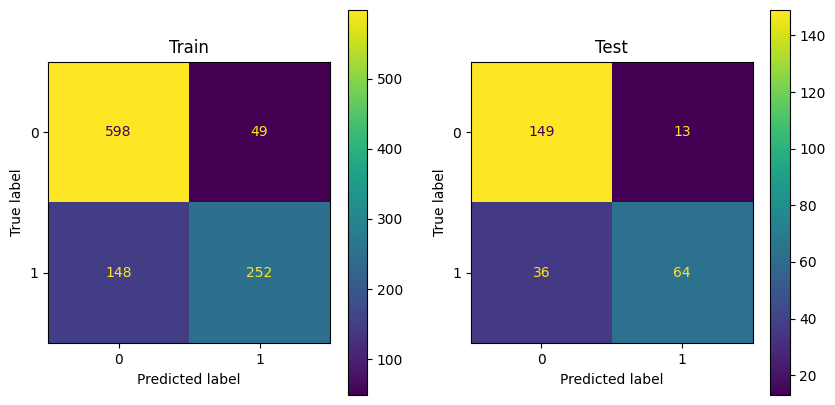

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

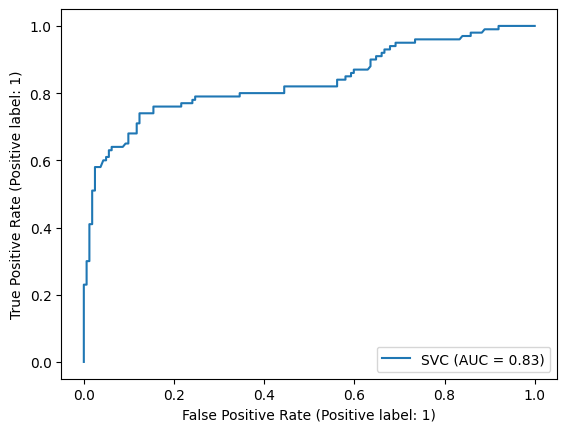

In [ ]:
RocCurveDisplay.from_estimator(svc,X_test,y_test)

# Klasyfikacja 2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [ ]:
metrics2 = {"accuracy":[], "precision":[], "recall":[], "f1-score":[]}

## Perceptron

Na początek zaczniemy od zwykłego perceptrona

In [ ]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train, y_train)

Perceptron(eta0=0.1, random_state=1)

In [ ]:
y_pred_train = ppn.predict(X_train)
y_pred_test = ppn.predict(X_test)

In [ ]:
metrics2["accuracy"].append(accuracy_score(y_test, y_pred_test))
metrics2["precision"].append(precision_score(y_test, y_pred_test))
metrics2["recall"].append(recall_score(y_test, y_pred_test))
metrics2["f1-score"].append(f1_score(y_test, y_pred_test))

In [ ]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       162
           1       0.72      0.56      0.63       100

    accuracy                           0.75       262
   macro avg       0.74      0.71      0.72       262
weighted avg       0.74      0.75      0.74       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train, cm_test

(array([[556,  91],
        [186, 214]]),
 array([[140,  22],
        [ 44,  56]]))

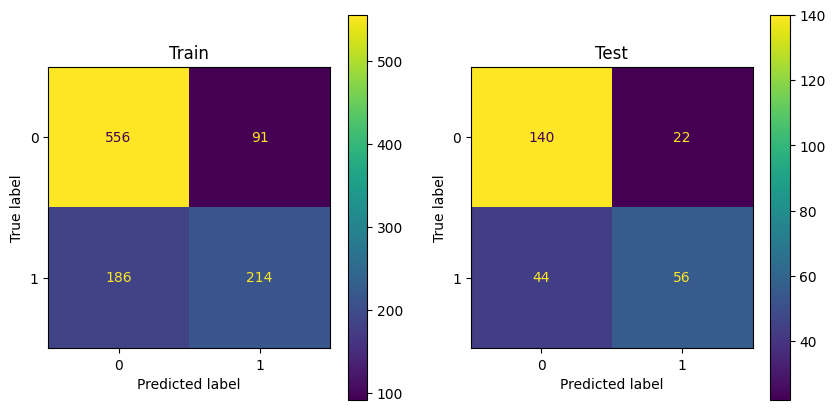

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

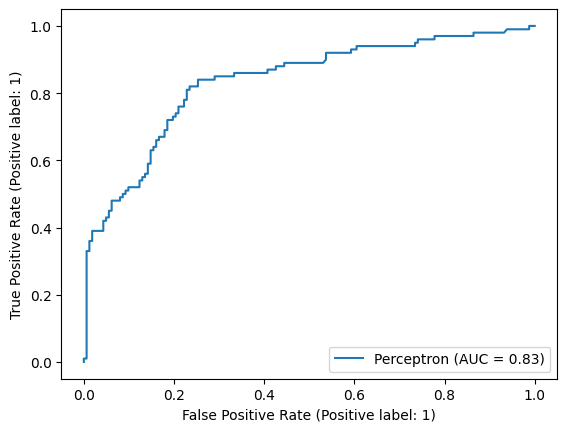

In [ ]:
RocCurveDisplay.from_estimator(ppn,X_test,y_test)

## SGDClassifier


In [ ]:
sgd = SGDClassifier(loss="log_loss").fit(X_train,y_train)

In [ ]:
y_pred_train_sgd = sgd.predict(X_train)
y_pred_train_sgd

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
y_pred_test_sgd = sgd.predict(X_test)
metrics2["accuracy"].append(accuracy_score(y_test, y_pred_test_sgd))
metrics2["precision"].append(precision_score(y_test, y_pred_test_sgd))
metrics2["recall"].append(recall_score(y_test, y_pred_test_sgd))
metrics2["f1-score"].append(f1_score(y_test, y_pred_test_sgd))

In [ ]:
print(classification_report(y_test,y_pred_test_sgd))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       162
           1       0.81      0.67      0.73       100

    accuracy                           0.81       262
   macro avg       0.81      0.79      0.79       262
weighted avg       0.81      0.81      0.81       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_sgd)
cm_test = confusion_matrix(y_test, y_pred_test_sgd)
cm_train, cm_test

(array([[577,  70],
        [143, 257]]),
 array([[146,  16],
        [ 33,  67]]))

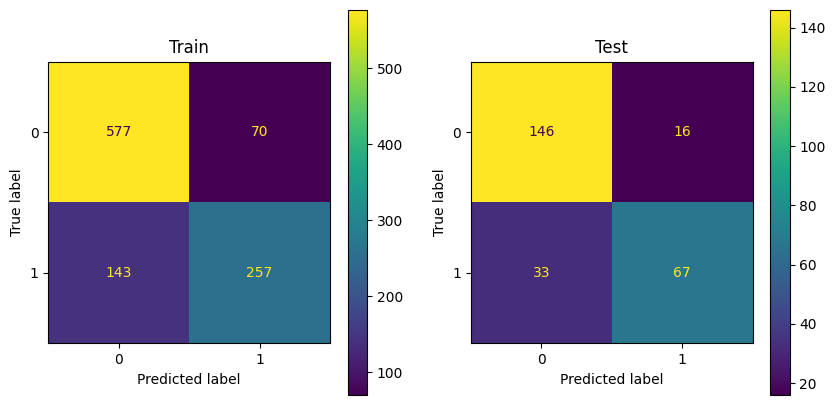

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

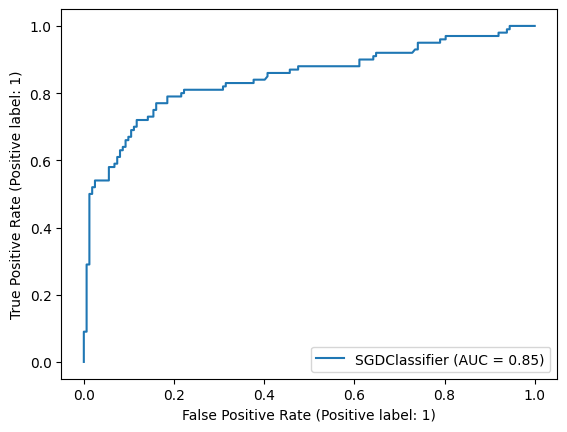

In [ ]:
RocCurveDisplay.from_estimator(sgd,X_test,y_test)

## DecisionTreeClassifier


[Text(0.5267857142857143, 0.9, 'x[7] <= 0.5\ngini = 0.472\nsamples = 1047\nvalue = [647, 400]'),
 Text(0.2857142857142857, 0.7, 'x[3] <= 0.182\ngini = 0.315\nsamples = 674\nvalue = [542, 132]'),
 Text(0.14285714285714285, 0.5, 'x[2] <= 0.35\ngini = 0.497\nsamples = 69\nvalue = [32, 37]'),
 Text(0.07142857142857142, 0.3, 'x[0] <= 0.21\ngini = 0.426\nsamples = 52\nvalue = [16, 36]'),
 Text(0.03571428571428571, 0.1, 'gini = 0.238\nsamples = 29\nvalue = [4, 25]'),
 Text(0.10714285714285714, 0.1, 'gini = 0.499\nsamples = 23\nvalue = [12, 11]'),
 Text(0.21428571428571427, 0.3, 'x[4] <= 0.5\ngini = 0.111\nsamples = 17\nvalue = [16, 1]'),
 Text(0.17857142857142858, 0.1, 'gini = 0.0\nsamples = 16\nvalue = [16, 0]'),
 Text(0.25, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.42857142857142855, 0.5, 'x[4] <= 0.5\ngini = 0.265\nsamples = 605\nvalue = [510, 95]'),
 Text(0.35714285714285715, 0.3, 'x[1] <= 0.795\ngini = 0.213\nsamples = 478\nvalue = [420, 58]'),
 Text(0.32142857142857145, 0

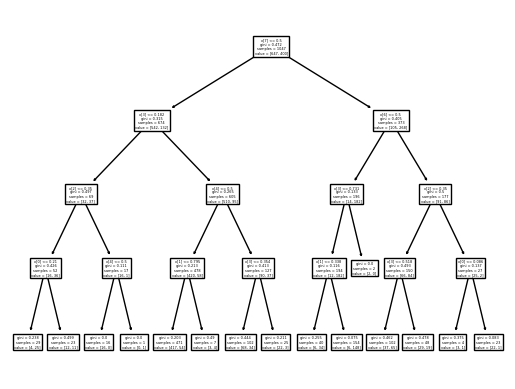

In [ ]:
DTC = DecisionTreeClassifier(max_depth=4).fit(X_train,y_train)
plot_tree(DTC)

In [ ]:
y_pred_train_DTC = DTC.predict(X_train)
y_pred_train_DTC

array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
y_pred_test_DTC = DTC.predict(X_test)
metrics2["accuracy"].append(accuracy_score(y_test, y_pred_test_DTC))
metrics2["precision"].append(precision_score(y_test, y_pred_test_DTC))
metrics2["recall"].append(recall_score(y_test, y_pred_test_DTC))
metrics2["f1-score"].append(f1_score(y_test, y_pred_test_DTC))

In [ ]:
print(classification_report(y_test,y_pred_test_DTC))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       162
           1       0.80      0.69      0.74       100

    accuracy                           0.82       262
   macro avg       0.81      0.79      0.80       262
weighted avg       0.82      0.82      0.81       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_DTC)
cm_test = confusion_matrix(y_test, y_pred_test_DTC)
cm_train, cm_test

(array([[591,  56],
        [123, 277]]),
 array([[145,  17],
        [ 31,  69]]))

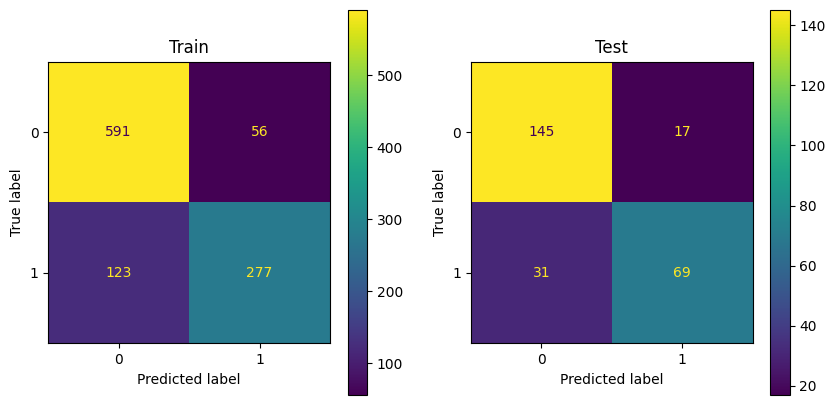

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

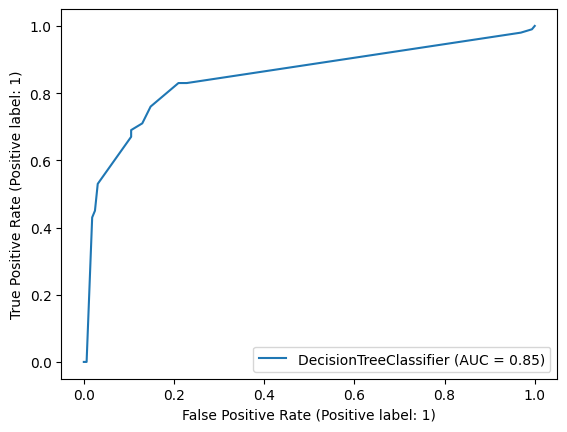

In [ ]:
RocCurveDisplay.from_estimator(DTC,X_test,y_test)

## LogisticRegresion

In [ ]:
lr = LogisticRegression().fit(X_train,y_train)

In [ ]:
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)
metrics2["accuracy"].append(accuracy_score(y_test, y_pred_test_lr))
metrics2["precision"].append(precision_score(y_test, y_pred_test_lr))
metrics2["recall"].append(recall_score(y_test, y_pred_test_lr))
metrics2["f1-score"].append(f1_score(y_test, y_pred_test_lr))

In [ ]:
print(classification_report(y_test,y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       162
           1       0.79      0.69      0.74       100

    accuracy                           0.81       262
   macro avg       0.81      0.79      0.80       262
weighted avg       0.81      0.81      0.81       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_lr)
cm_test = confusion_matrix(y_test, y_pred_test_lr)
cm_train, cm_test

(array([[570,  77],
        [138, 262]]),
 array([[144,  18],
        [ 31,  69]]))

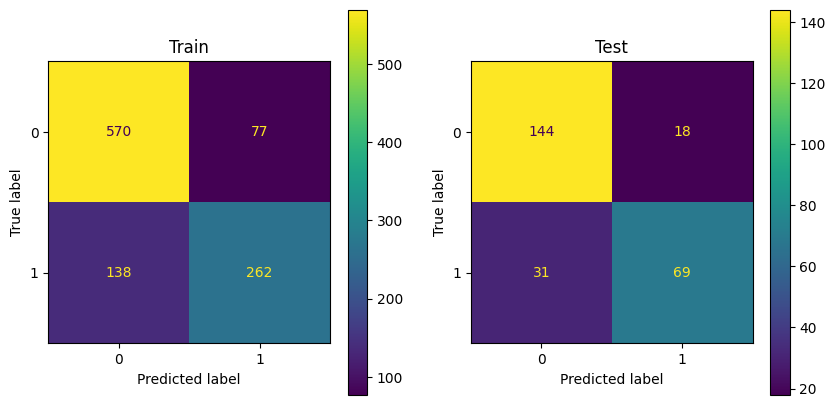

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

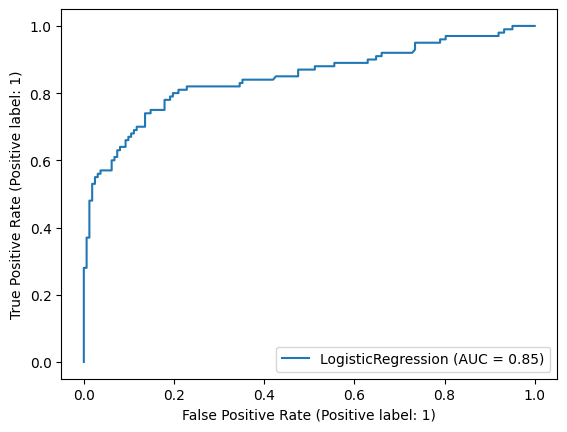

In [ ]:
RocCurveDisplay.from_estimator(lr,X_test,y_test)

## KNeighborsClassifier

In [ ]:
kn = KNeighborsClassifier().fit(X_train,y_train)

In [ ]:
y_pred_train_kn = kn.predict(X_train)
y_pred_test_kn = kn.predict(X_test)
metrics2["accuracy"].append(accuracy_score(y_test, y_pred_test_kn))
metrics2["precision"].append(precision_score(y_test, y_pred_test_kn))
metrics2["recall"].append(recall_score(y_test, y_pred_test_kn))
metrics2["f1-score"].append(f1_score(y_test, y_pred_test_kn))

In [ ]:
print(classification_report(y_test,y_pred_test_kn))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       162
           1       0.78      0.73      0.75       100

    accuracy                           0.82       262
   macro avg       0.81      0.80      0.80       262
weighted avg       0.82      0.82      0.82       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_kn)
cm_test = confusion_matrix(y_test, y_pred_test_kn)
cm_train, cm_test

(array([[583,  64],
        [101, 299]]),
 array([[141,  21],
        [ 27,  73]]))

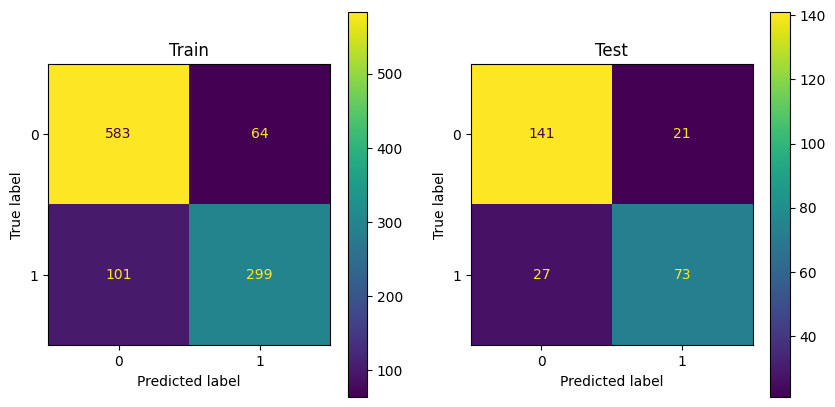

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

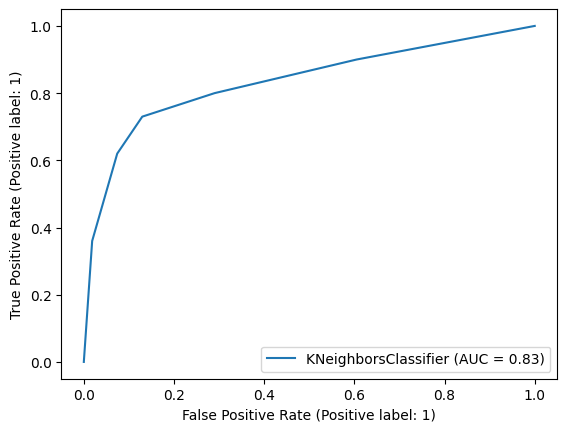

In [ ]:
RocCurveDisplay.from_estimator(kn,X_test,y_test)

## RandomForestClassifier


In [ ]:
rfc = RandomForestClassifier().fit(X_train,y_train)

In [ ]:
y_pred_train_rfc = rfc.predict(X_train)
y_pred_test_rfc = rfc.predict(X_test)
metrics2["accuracy"].append(accuracy_score(y_test, y_pred_test_rfc))
metrics2["precision"].append(precision_score(y_test, y_pred_test_rfc))
metrics2["recall"].append(recall_score(y_test, y_pred_test_rfc))
metrics2["f1-score"].append(f1_score(y_test, y_pred_test_rfc))

In [ ]:
print(classification_report(y_test,y_pred_test_rfc))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       162
           1       0.76      0.74      0.75       100

    accuracy                           0.81       262
   macro avg       0.80      0.80      0.80       262
weighted avg       0.81      0.81      0.81       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_rfc)
cm_test = confusion_matrix(y_test, y_pred_test_rfc)
cm_train, cm_test

(array([[635,  12],
        [ 20, 380]]),
 array([[138,  24],
        [ 26,  74]]))

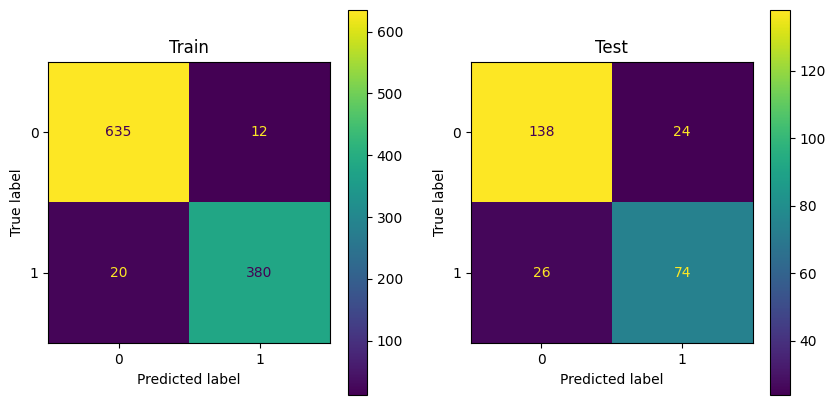

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

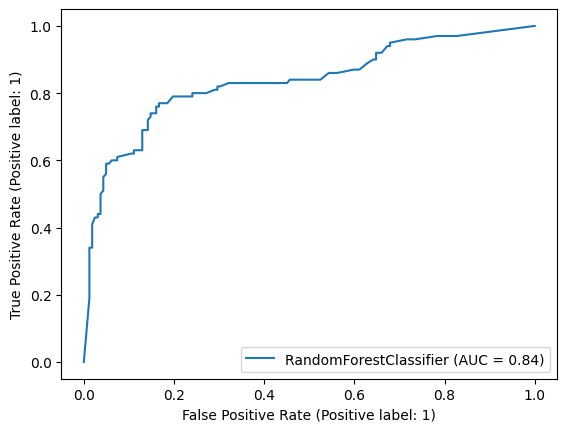

In [ ]:
RocCurveDisplay.from_estimator(rfc,X_test,y_test)

## SVC

In [ ]:
svc = SVC().fit(X_train,y_train)

In [ ]:
y_pred_train_svc = svc.predict(X_train)
y_pred_test_svc = svc.predict(X_test)
metrics2["accuracy"].append(accuracy_score(y_test, y_pred_test_svc))
metrics2["precision"].append(precision_score(y_test, y_pred_test_svc))
metrics2["recall"].append(recall_score(y_test, y_pred_test_svc))
metrics2["f1-score"].append(f1_score(y_test, y_pred_test_svc))

In [ ]:
print(classification_report(y_test,y_pred_test_svc))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       162
           1       0.80      0.70      0.74       100

    accuracy                           0.82       262
   macro avg       0.81      0.79      0.80       262
weighted avg       0.82      0.82      0.81       262



In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train_svc)
cm_test = confusion_matrix(y_test, y_pred_test_svc)
cm_train, cm_test

(array([[577,  70],
        [130, 270]]),
 array([[144,  18],
        [ 30,  70]]))

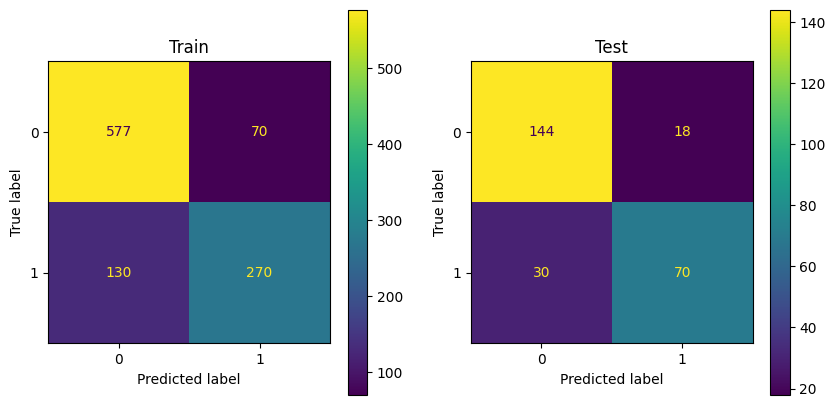

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

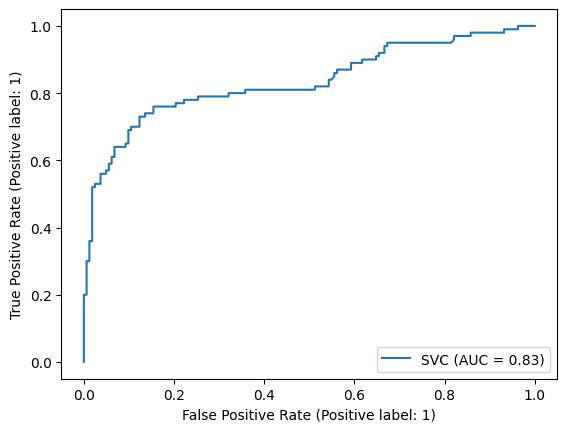

In [ ]:
RocCurveDisplay.from_estimator(svc,X_test,y_test)

# Podsumowanie


## Mniejszy zbiór

In [ ]:
summary = pd.DataFrame(data=metrics,index=["Perceptron","SGD","DecisionTreeClassifier","LogisticRegression","KNeighboursClassifier","RandomForestClassifier","SVC"])
summary

,accuracy,precision,recall,f1-score
Perceptron,0.767176,0.666667,0.78,0.718894
SGD,0.809160,0.931034,0.54,0.683544
DecisionTreeClassifier,0.801527,0.766667,0.69,0.726316
LogisticRegression,0.812977,0.786517,0.70,0.740741
KNeighboursClassifier,0.801527,0.760870,0.70,0.729167
RandomForestClassifier,0.801527,0.740000,0.74,0.740000
SVC,0.812977,0.831169,0.64,0.723164


<Axes: >

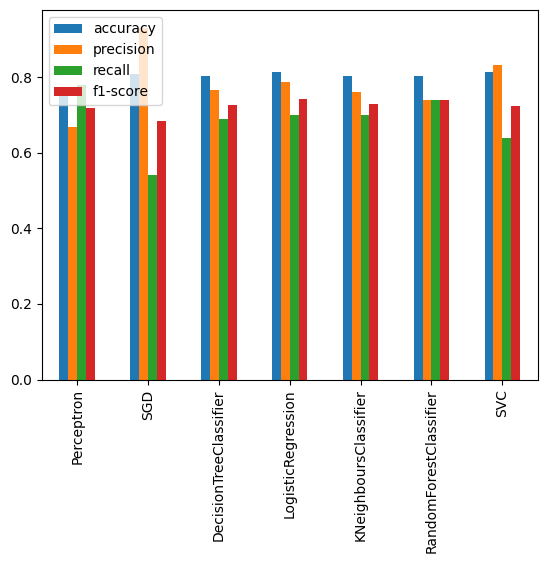

In [ ]:
summary.plot.bar()

## Większy zbiór

In [ ]:
summary = pd.DataFrame(data=metrics2,index=["Perceptron","SGD","DecisionTreeClassifier","LogisticRegression","KNeighboursClassifier","RandomForestClassifier","SVC"])
summary

,accuracy,precision,recall,f1-score
Perceptron,0.748092,0.717949,0.56,0.629213
SGD,0.812977,0.807229,0.67,0.732240
DecisionTreeClassifier,0.816794,0.802326,0.69,0.741935
LogisticRegression,0.812977,0.793103,0.69,0.737968
KNeighboursClassifier,0.816794,0.776596,0.73,0.752577
RandomForestClassifier,0.809160,0.755102,0.74,0.747475
SVC,0.816794,0.795455,0.70,0.744681


<Axes: >

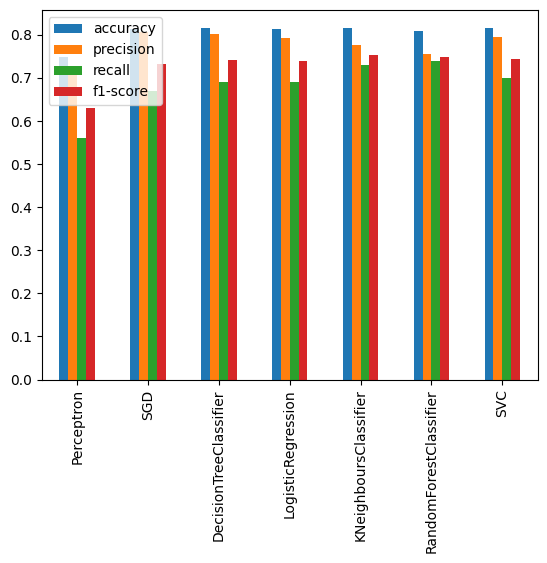

In [ ]:
summary.plot.bar()